In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt
from sklearn import linear_model
import seaborn as sb


In [2]:
path = "./loan.csv"
inputDf = pd.read_csv(path, sep = ",", low_memory=False)

In [3]:
selectedCols = inputDf.copy(deep = True)

# Part One - Data Exploration

### parse data into numeric where relevant

In [4]:
termDummies = pd.get_dummies(selectedCols["term"]).drop(columns = [" 36 months"])
selectedCols = termDummies.join(selectedCols.drop(columns = ["term"]))
selectedCols.head()

,60 months,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000.0,5000.0,4975.0,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500.0,2500.0,2500.0,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1077175,1313524,2400.0,2400.0,2400.0,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1076863,1277178,10000.0,10000.0,10000.0,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1075358,1311748,3000.0,3000.0,3000.0,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
selectedCols["origYear"] = selectedCols["issue_d"].str.extract("\w{3}-(\d{4})")
selectedCols = selectedCols.drop(columns= ["issue_d"])

In [6]:
typedDf = selectedCols.copy(deep = True)

## look at distributions

In [7]:
# looking at data types
typedDf.dtypes

 60 months                       uint8
id                               int64
member_id                        int64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
earliest_cr_line         

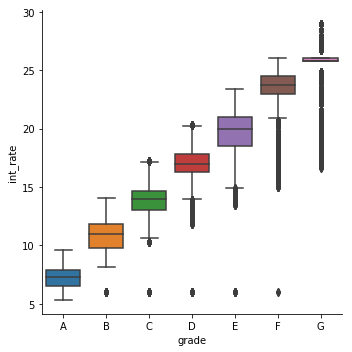

In [8]:
sb.catplot(x="grade", y="int_rate", data=typedDf, kind="box", order = ("A", "B", "C", "D", "E", "F","G"))
## worried that grades and interest rates lead to multicolinearity problems
## also notice that all grades except A and G have some sort of 'outlier' interest rate at 5%.

In [9]:
# convert grades to numerics
gradeDummies = pd.get_dummies(selectedCols["grade"], prefix="grade")
selectedColsNoGrade = typedDf.drop(columns=["grade"])
dummiedGradesDf = gradeDummies.join(selectedColsNoGrade)
del selectedColsNoGrade
del selectedCols

In [10]:
dummiedGradesDf["grade"] = dummiedGradesDf["grade_A"] * 0 + \
    dummiedGradesDf["grade_B"] * 2 + dummiedGradesDf["grade_C"] * 3 + dummiedGradesDf["grade_D"] * 4  + \
    dummiedGradesDf["grade_E"] * 5 + dummiedGradesDf["grade_F"] * 6 + dummiedGradesDf["grade_G"] * 6
dummiedGradesDf = dummiedGradesDf.drop(columns=["grade_A", "grade_B", "grade_C", "grade_D", "grade_E", "grade_F", "grade_G"])

In [11]:
typedDf = dummiedGradesDf

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


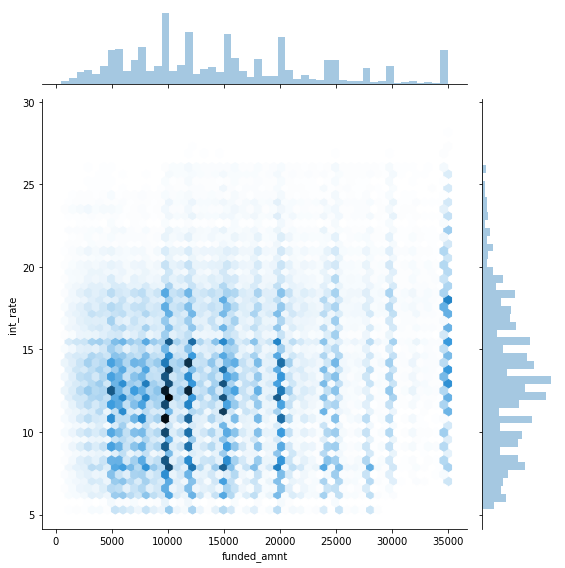

In [12]:
import matplotlib.pyplot as plt
sb.jointplot(x="funded_amnt", y="int_rate", data = typedDf, kind="hex", height =8)

#looks like there is some sort of upper bound on loan size at 35k - this could be due to lending club rules.

#### not surprising that annual income is highly skewed... lets reduce skew

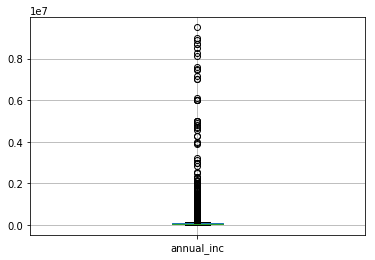

In [13]:
boxplot = typedDf.boxplot(column=['annual_inc'])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


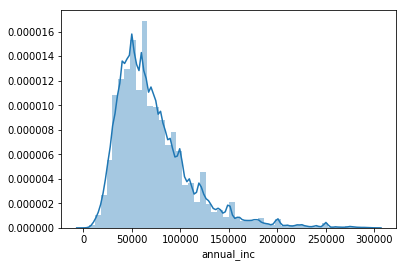

In [14]:
incomeFilter = typedDf[typedDf["annual_inc"] < 300000]
sb.distplot(incomeFilter["annual_inc"].dropna())

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


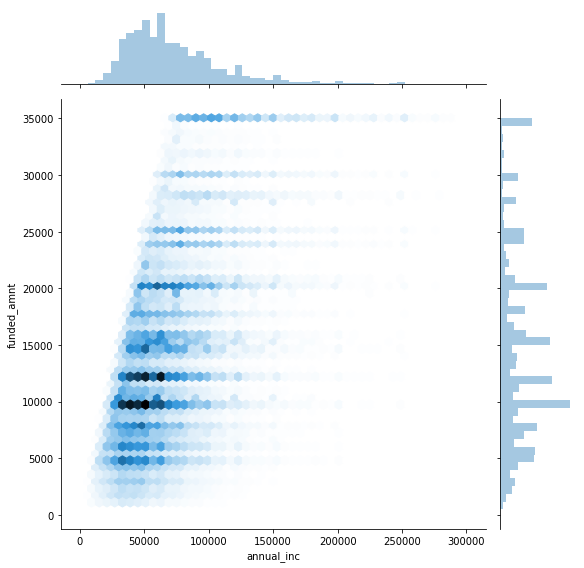

In [82]:
import matplotlib.pyplot as plt
sb.jointplot(x="annual_inc", y="funded_amnt", data = incomeFilter, kind="hex", height = 8)

#notice tendency of higher incomes to take larger loans as evidenced by emptiness of top left quartile.

### Look at Correlations

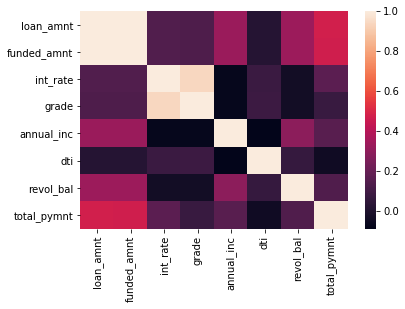

In [16]:
sb.heatmap(typedDf[["loan_amnt", "funded_amnt",
                    "int_rate", "grade", "annual_inc", "dti",
                    "revol_bal", "total_pymnt", "loan_status"]].corr())

funded amt and loan amount are highly correlated, this is trivial

interest rate and grade highly correlated (as seen above in box/whisker)

### look at distributions

In [78]:
### everything is skewed right, except grade which is perfectly balanced
### DTI seems to have an outlier, or is 9999 a null placeholder ?
normalized = typedDf.copy(deep = True)
normalized.drop(columns = ["member_id"]).describe()

,60 months,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,grade
count,887379.000000,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,...,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171030e+05,21372.000000,21372.000000,21372.000000,887379.000000
mean,0.300045,3.246513e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,18.157039,0.314442,...,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206862e+04,0.943945,1.537058,1.977307,2.625206
std,0.458278,2.282734e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,17.190626,0.862244,...,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749826e+04,1.446872,2.723339,2.874067,1.553977
min,0.000000,5.473400e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000,0.000000
25%,0.000000,9.206643e+06,8000.000000,8000.000000,8000.000000,9.990000,260.705000,4.500000e+04,11.910000,0.000000,...,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000,2.000000
50%,0.000000,3.443327e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.500000e+04,17.650000,0.000000,...,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.000000,0.000000,2.000000,3.000000
75%,1.000000,5.490814e+07,20000.000000,20000.000000,20000.000000,16.200000,572.600000,9.000000e+04,23.950000,0.000000,...,87.600000,2.000000,4.000000,7771.500000,75.200000,3.980000e+04,1.000000,2.000000,3.000000,4.000000
max,1.000000,6.861706e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,9999.000000,39.000000,...,223.300000,22.000000,43.000000,127305.000000,151.400000,9.999999e+06,17.000000,35.000000,32.000000,6.000000


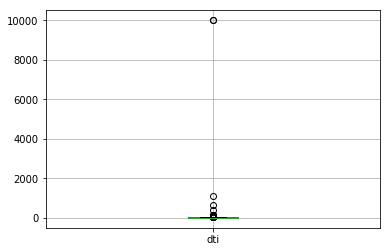

In [18]:
#looks like dti= 9999 is a null placeholder because there are few values between ~ 1000 and that 9999 value
dti = typedDf[["dti"]]
boxplot = dti.boxplot(column=['dti'])

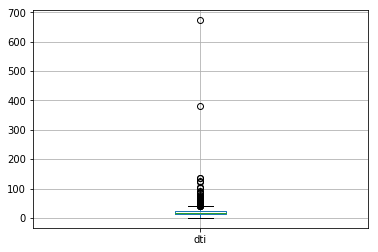

In [19]:
#looks much better if we remove 9999 - still heavily skewed though.
dti[dti["dti"] < 900 ].boxplot(column=['dti'])

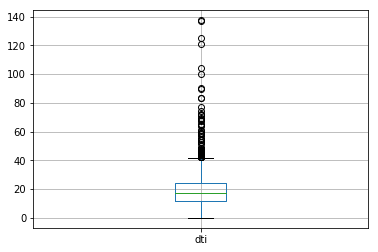

In [20]:
# much nicer if we remove outliers ( > 300)
dti[dti["dti"] < 300 ].boxplot(column=['dti'])

In [21]:
def normalize(df, col):
    ser = df[[col]]
    normalized_ser=(ser-ser.min())/(ser.max()-ser.min())
    df.drop(columns=[col])
    df[col] = normalized_ser
    return df

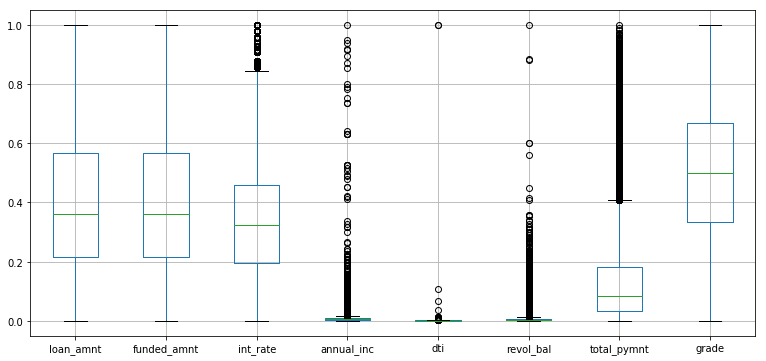

In [22]:
normalizeDf = typedDf.copy(deep = True)

normalize(normalizeDf, "loan_amnt")
normalize(normalizeDf, "funded_amnt")
normalize(normalizeDf, "int_rate")
normalize(normalizeDf, "annual_inc")
normalize(normalizeDf, "dti")
normalize(normalizeDf, "revol_bal")
normalize(normalizeDf, "total_pymnt")
normalize(normalizeDf, "grade")
normalizeDf.boxplot(column=["loan_amnt", "funded_amnt", "int_rate", "annual_inc",
                                  "dti", "revol_bal", "total_pymnt", "grade"], figsize=(13,6))

In [23]:
del normalized
del normalizeDf

In [24]:
#Confirms suspicions of bad skew.
# annual income being the worst offender. nothing to do now other than just keep note for later stages
typedDf[["loan_amnt", "funded_amnt", "int_rate", "annual_inc",
          "dti", "revol_bal", "total_pymnt", "grade"]].skew(axis = 0)

loan_amnt        0.681683
funded_amnt      0.683745
int_rate         0.429481
annual_inc      44.478487
dti            441.486775
revol_bal       15.949302
total_pymnt      1.788894
grade           -0.097367
dtype: float64

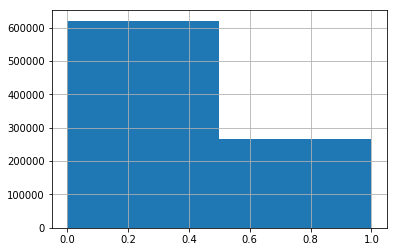

In [25]:
hist = typedDf[" 60 months"].hist(bins=2)
## most loans are 36 month

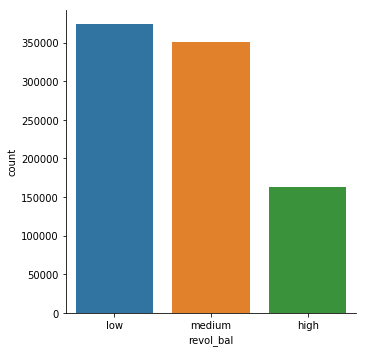

In [26]:
revolveStudy = typedDf.copy(deep = True)
revolveStudy["revol_bal"] = pd.cut(typedDf["revol_bal"], bins = [-2, 10000, 25000, 5000000], labels = ["low", "medium", "high"])
sb.catplot(x="revol_bal", kind="count", data=revolveStudy)

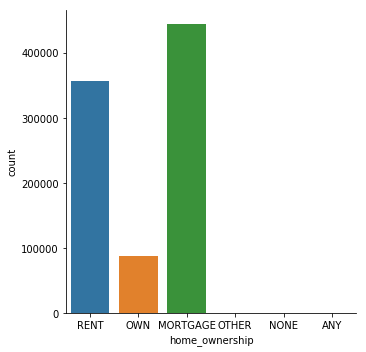

In [27]:
sb.catplot(x="home_ownership", kind="count", data=typedDf)

# Part Two - Business Analysis
#### this did not say to balance weight, but this should be balance weighted

In [28]:
##only look at 36 month loans
shortTerm = typedDf[typedDf[" 60 months"] == 0]

In [29]:
shortTerm.loan_status.value_counts()

Current                                                402848
Fully Paid                                             167575
Charged Off                                             29083
Late (31-120 days)                                       7026
Issued                                                   5982
In Grace Period                                          3975
Does not meet the credit policy. Status:Fully Paid       1789
Late (16-30 days)                                        1483
Default                                                   715
Does not meet the credit policy. Status:Charged Off       649
Name: loan_status, dtype: int64

In [30]:
## only look at loans that are no longer alive 
# assuming that if they are done paying they are in one of three categories below
# not sure what: "Does not meet the credit policy. Status:Charged Off", "Does not meet the credit policy. Status:Charged Off"
shortTerm = shortTerm[(shortTerm["loan_status"] == "Fully Paid") | (shortTerm["loan_status"] == "Charged Off") | 
                    (shortTerm["loan_status"] == "Default")]

In [31]:
shortTerm.head()

,60 months,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,sub_grade,emp_title,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,origYear,grade
0,0,1077501,1296599,5000.0,5000.0,4975.0,10.65,162.87,B2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,2
2,0,1077175,1313524,2400.0,2400.0,2400.0,15.96,84.33,C5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,3
3,0,1076863,1277178,10000.0,10000.0,10000.0,13.49,339.31,C1,AIR RESOURCES BOARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,3
5,0,1075269,1311441,5000.0,5000.0,5000.0,7.90,156.46,A4,Veolia Transportaton,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,0
7,0,1072053,1288686,3000.0,3000.0,3000.0,18.64,109.43,E1,MKC Accounting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5


#### Pct loans fully paid

In [32]:
relFreqs = shortTerm["loan_status"].value_counts() / shortTerm["loan_status"].dropna().size
counts = shortTerm["loan_status"].value_counts()
print("there are {} loans fully paid, which represents {} loans".format(counts[0].round(4), relFreqs[0].round(4)))

there are 167575 loans fully paid, which represents 0.849 loans


In [33]:
resultDf = pd.get_dummies(shortTerm["loan_status"])

In [34]:
weightedPaidOff = (resultDf[["Fully Paid"]].astype(float).values *  shortTerm[["loan_amnt"]].astype(float).values).sum()

In [35]:
wavgLoanPaidOff = weightedPaidOff / shortTerm[["loan_amnt"]].astype(float).values.sum()

In [36]:
print("""The balance weighted avg of loans that paid off is {}, 
as this is slightly larger than the non-weighted pct of loans, we conclude the 
loans that pay off fully are higher balance than average""".format(wavgLoanPaidOff.round(4)))

The balance weighted avg of loans that paid off is 0.8504, 
as this is slightly larger than the non-weighted pct of loans, we conclude the 
loans that pay off fully are higher balance than average


#### highest rates of default

In [37]:
defaultDf = shortTerm[["origYear", "grade", "loan_status", "loan_amnt"]]

In [38]:
statusDummies = pd.get_dummies(defaultDf["loan_status"])
defaultDf["defaulted"] = (statusDummies[["Fully Paid"]] * - 1) + 1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
defaultGroupings = defaultDf.groupby(['origYear', 'grade']).mean()
cohorts = defaultGroupings.sort_values(by = "defaulted", ascending = False)
maxDefaults = cohorts.iloc[:1,]
print(maxDefaults)
print("the highest default rate of 0.48 was found among 2008 G's !")

                loan_amnt  defaulted
origYear grade                      
2008     6        17355.0       0.48
the highest default rate of 0.48 was found among 2008 G's !


In [81]:
defaultGroupings.unstack()

loan_amnt                                            \
grade                0             2             3             4   
origYear                                                           
2007       5492.105263   9423.360656   8910.333333   9985.135135   
2008       6370.593220   9522.633136   8903.538813  10739.639640   
2009       7238.264007  10932.600733   9786.022632  11000.076104   
2010       8601.239669  10395.487668   9195.692935  11136.551233   
2011       8960.284101   9554.071368   9028.983205  10579.639175   
2012      11117.742761  11003.840186  11505.734340  13850.488841   
2013      15161.814175  12902.093166  12308.070977  10668.799792   
2014      14028.026530  12343.910414  11835.029310  11343.604651   
2015      13360.210071  11605.380251  11110.070327  12126.353582   

                                     defaulted                                \
grade                5             6         0         2         3         4   
origYear                                                                       
2007      14896.428571  12160.714286  0.017544  0.131148  0.186667  0.405405   
2008      12868.666667  17355.000000  0.057627  0.145957  0.178082  0.243243   
2009      12581.250000  12824.137931  0.067063  0.114286  0.147527  0.171994   
2010      12544.833948  17750.297619  0.043684  0.092676  0.127174  0.161290   
2011      13306.801471  13944.921875  0.063990  0.105676  0.155243  0.180809   
2012      20197.088608  20857.086614  0.071874  0.124963  0.175248  0.210350   
2013      10528.041977  10502.150538  0.065538  0.138637  0.215812  0.286572   
2014      11015.767519   9854.029304  0.062371  0.126243  0.206138  0.276868   
2015      13326.607884  11016.040462  0.031820  0.066494  0.106592  0.166061   

                              
grade            5         6  
origYear                      
2007      0.357143  0.285714  
2008      0.160000  0.480000  
2009      0.216102  0.218391  
2010      0.191882  0.321429  
2011      0.205882  0.265625  
2012      0.218987  0.181102  
2013      0.334219  0.381720  
2014      0.351502  0.411477  
2015      0.243776  0.283237

In [40]:
defaultDf["weightedAmnt"] = defaultDf["defaulted"].astype(float).values *  defaultDf["loan_amnt"].astype(float).values 
defaultWeighted = defaultDf.groupby(["origYear", "grade"]).agg({'weightedAmnt': ['sum'], 'loan_amnt': 'sum'})
defaultWeighted = defaultWeighted["weightedAmnt"].astype(float) / defaultWeighted["loan_amnt"].astype(float)
defaultWeighted.sort_values(by = "sum", ascending = False).head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,,sum
origYear,grade,
2008,6,0.500144
2007,5,0.479861
2014,6,0.448064
2013,6,0.409977
2014,5,0.368841


##### 2008 G's are still the highest default prob when weighted by loan size at 50% chance of default

### annualized rate of return

In [41]:
rateReturn = shortTerm

In [42]:
rateReturn["annualizedRateReturn"] = np.power((rateReturn["total_pymnt"] / rateReturn["funded_amnt"]), 1/3) - 1

In [43]:
rateReturn = rateReturn[["annualizedRateReturn", "origYear", "grade"]]

In [80]:
rateReturn.head()

,annualizedRateReturn,origYear,grade
0,0.054393,2011,2
2,0.077654,2011,3
3,0.069297,2011,3
5,0.040435,2011,0
7,0.094940,2011,5


In [45]:
returnCohorts = rateReturn.groupby(['origYear', 'grade']).mean()
returnCohorts = returnCohorts.sort_values(by = "annualizedRateReturn", ascending = False)

#### below is a summary of the annualized rate of return for each cohort (grouped by origination year and grade)

In [46]:
rateReturn.groupby(['origYear', 'grade']).mean().unstack()

annualizedRateReturn                                          \
grade                       0         2         3         4         5   
origYear                                                                
2007                 0.027176  0.012265  0.012208 -0.023199 -0.009098   
2008                 0.025285  0.009916  0.009593 -0.010402  0.022560   
2009                 0.021317  0.017141  0.014591  0.018891  0.002592   
2010                 0.021648  0.023139  0.024831  0.023060  0.018264   
2011                 0.014910  0.021848  0.017563  0.021422  0.024065   
2012                 0.015651  0.023376  0.021841  0.023836  0.031327   
2013                 0.011632  0.006965 -0.002854 -0.014875 -0.026810   
2014                -0.002589 -0.013946 -0.037361 -0.057194 -0.079325   
2015                -0.012722 -0.026685 -0.043013 -0.071553 -0.108845   

                    
grade            6  
origYear            
2007      0.031161  
2008     -0.071268  
2009      0.030043  
2010     -0.010835  
2011      0.015600  
2012      0.034269  
2013     -0.045979  
2014     -0.094071  
2015     -0.134226

# Part 3 - Modeling

In [47]:
modelDf = typedDf.copy(deep = True)
modelDf.head()

,60 months,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,sub_grade,emp_title,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,origYear,grade
0,0,1077501,1296599,5000.0,5000.0,4975.0,10.65,162.87,B2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,2
1,1,1077430,1314167,2500.0,2500.0,2500.0,15.27,59.83,C4,Ryder,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,3
2,0,1077175,1313524,2400.0,2400.0,2400.0,15.96,84.33,C5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,3
3,0,1076863,1277178,10000.0,10000.0,10000.0,13.49,339.31,C1,AIR RESOURCES BOARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,3
4,1,1075358,1311748,3000.0,3000.0,3000.0,12.69,67.79,B5,University Medical Group,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,2


let's get rid of outliers we detected in part 1

In [48]:
modelDf = modelDf[modelDf["dti"] < 300]

In [49]:
modelDf = modelDf[modelDf["annual_inc"] < 300000]

In [50]:
balCuts = pd.cut(modelDf["revol_bal"], bins = [-2, 10000, 25000, 5000000], labels = ["low", "medium", "high"])
modelDf = modelDf.join(pd.get_dummies(balCuts, prefix="revol_bal")).drop(columns = ["revol_bal"])


In [51]:
modelDf = modelDf[(modelDf["loan_status"] == "Fully Paid") |
                                          (modelDf["loan_status"] == "Charged Off") |
                                          (modelDf["loan_status"] == "Default")]
statusDummies = pd.get_dummies(modelDf["loan_status"])
modelDf["defaulted"] = (statusDummies[["Fully Paid"]] * - 1) + 1

### first pass using the variables used in data analysis thus far

In [52]:
firstPassRegression = modelDf[["loan_amnt", " 60 months", "int_rate", "annual_inc", 
         "dti", "revol_bal_low", "revol_bal_medium", "revol_bal_high", "total_pymnt", "loan_status"]]

### create features / labels

In [53]:
firstPassRegression = firstPassRegression[(firstPassRegression["loan_status"] == "Fully Paid") |
                                          (firstPassRegression["loan_status"] == "Charged Off") |
                                          (firstPassRegression["loan_status"] == "Default")]
statusDummies = pd.get_dummies(firstPassRegression["loan_status"])
firstPassRegression["defaulted"] = (statusDummies[["Fully Paid"]] * - 1) + 1

In [54]:
labels = firstPassRegression["defaulted"]
features = firstPassRegression.drop(columns=["defaulted", "loan_status"])
features.skew()

loan_amnt           0.835559
 60 months          1.327907
int_rate            0.344773
annual_inc          1.664479
dti                 0.209818
revol_bal_low       0.162529
revol_bal_medium    0.458102
revol_bal_high      1.937187
total_pymnt         1.063420
dtype: float64

### split train and test

In [55]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [56]:
train_features.describe()

,loan_amnt,60 months,int_rate,annual_inc,dti,revol_bal_low,revol_bal_medium,revol_bal_high,total_pymnt
count,189673.000000,189673.000000,189673.000000,189673.000000,189673.000000,189673.000000,189673.000000,189673.000000,189673.000000
mean,13512.041382,0.223189,13.774905,70408.698074,16.598103,0.460261,0.387920,0.151819,13509.763273
std,8088.289041,0.416385,4.398564,37542.675402,7.771600,0.498420,0.487278,0.358846,9424.583792
min,500.000000,0.000000,5.320000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7200.000000,0.000000,10.740000,45000.000000,10.820000,0.000000,0.000000,0.000000,6335.830000
50%,12000.000000,0.000000,13.530000,62000.000000,16.260000,0.000000,0.000000,0.000000,11397.290000
75%,18125.000000,0.000000,16.550000,86000.000000,22.040000,1.000000,1.000000,0.000000,18471.350731
max,35000.000000,1.000000,28.990000,298000.000000,39.990000,1.000000,1.000000,1.000000,57777.579870


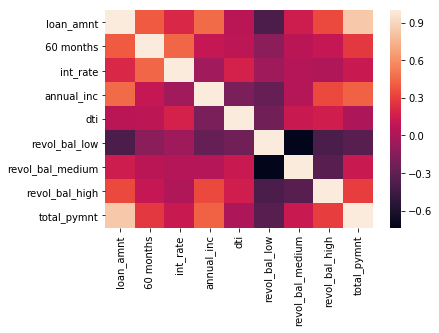

In [57]:
sb.heatmap(train_features.corr())

### Establish Baseline

In [58]:
from sklearn.dummy import DummyClassifier
freqentist = DummyClassifier(strategy='most_frequent')
freqentist.fit(train_features, train_labels)
print("baseline prediction accuracy is {}".format(freqentist.score(test_features, test_labels).round(4)))

baseline prediction accuracy is 0.8179


### Try multivariate linear regression

In [59]:
ols = linear_model.LinearRegression(normalize = False)
model = ols.fit(train_features, train_labels)

In [60]:
print("OLS regression has an R^2 of {} in sample".format(model.score(train_features, train_labels).round(4)))
print("OLS regression has an R^2 of {} out of sample".format(model.score(test_features, test_labels).round(4)))

OLS regression has an R^2 of 0.5977 in sample
OLS regression has an R^2 of 0.6024 out of sample



####  lets work harder on variable selection

In [61]:
varSelection = modelDf[["application_type", "collections_12_mths_ex_med", "earliest_cr_line", "emp_length",
         "funded_amnt", "grade", "home_ownership", "installment", "int_rate",
         "pub_rec", "revol_util", "total_acc", "grade",
         "acc_now_delinq", "recoveries", "loan_status"]]

In [62]:
varSelection = varSelection[(varSelection["loan_status"] == "Fully Paid") |
                                          (varSelection["loan_status"] == "Charged Off") |
                                          (varSelection["loan_status"] == "Default")]
statusDummies = pd.get_dummies(varSelection["loan_status"])
varSelection["defaulted"] = (statusDummies[["Fully Paid"]] * - 1) + 1

In [63]:
applicationDummies = pd.get_dummies(varSelection[["application_type", "home_ownership"]])
varSelection = varSelection.drop(columns = ["application_type", "home_ownership"])
applicationDummies = applicationDummies.drop(columns = ["application_type_INDIVIDUAL"])
varSelection = applicationDummies.join(varSelection)

In [64]:
varSelection["earliest_cr_line"] = varSelection["earliest_cr_line"].str.extract("\w{3}-(\d{4})").astype(float)
varSelection["emp_length"] = varSelection["emp_length"].str.extract("(\d+).*").astype(float)

In [65]:
varSelection = varSelection.dropna()

In [66]:
labels = varSelection["defaulted"]
features = varSelection.drop(columns=["defaulted", "loan_status"])
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242694 entries, 0 to 887369
Data columns (total 20 columns):
application_type_JOINT        242694 non-null uint8
home_ownership_ANY            242694 non-null uint8
home_ownership_MORTGAGE       242694 non-null uint8
home_ownership_NONE           242694 non-null uint8
home_ownership_OTHER          242694 non-null uint8
home_ownership_OWN            242694 non-null uint8
home_ownership_RENT           242694 non-null uint8
collections_12_mths_ex_med    242694 non-null float64
earliest_cr_line              242694 non-null float64
emp_length                    242694 non-null float64
funded_amnt                   242694 non-null float64
grade                         242694 non-null uint8
installment                   242694 non-null float64
int_rate                      242694 non-null float64
pub_rec                       242694 non-null float64
revol_util                    242694 non-null float64
total_acc                     242694 non-

In [67]:
from sklearn.feature_selection import SelectKBest
#take 5 strongest variables
from sklearn.feature_selection import chi2
X_new = SelectKBest(chi2, k=5).fit_transform(features, labels)
features = X_new

In [68]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.8, random_state = 42)

In [69]:
ols = linear_model.LinearRegression(normalize = False)
model = ols.fit(train_features, train_labels)

In [70]:
print("OLS regression has an R^2 of {} in sample".format(model.score(train_features, train_labels).round(4)))
print("OLS regression has an R^2 of {} out of sample".format(model.score(test_features, test_labels).round(4)))

OLS regression has an R^2 of 0.2451 in sample
OLS regression has an R^2 of 0.2343 out of sample


In [71]:
from sklearn.linear_model import Lasso

from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
res = clf.fit(train_features, train_labels)
score = res.score(test_features, test_labels)
print("LASSO regression has a score of {} out of sample".format(score.round(4)))

LASSO regression has a score of 0.2305 out of sample


#### let's be more strict about features - rank and remove

In [72]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(features, labels.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
rfe.score(test_features, test_labels)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[ True  True  True  True  True]
[1 1 1 1 1]


0.9138476276808339

### remove a few features according to rfe results

In [73]:
labels = varSelection["defaulted"]
features = varSelection.drop(columns=["defaulted", "loan_status", "application_type_JOINT", "home_ownership_ANY", "home_ownership_NONE"])
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242694 entries, 0 to 887369
Data columns (total 17 columns):
home_ownership_MORTGAGE       242694 non-null uint8
home_ownership_OTHER          242694 non-null uint8
home_ownership_OWN            242694 non-null uint8
home_ownership_RENT           242694 non-null uint8
collections_12_mths_ex_med    242694 non-null float64
earliest_cr_line              242694 non-null float64
emp_length                    242694 non-null float64
funded_amnt                   242694 non-null float64
grade                         242694 non-null uint8
installment                   242694 non-null float64
int_rate                      242694 non-null float64
pub_rec                       242694 non-null float64
revol_util                    242694 non-null float64
total_acc                     242694 non-null float64
grade                         242694 non-null uint8
acc_now_delinq                242694 non-null float64
recoveries                    242694 

In [74]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.8, random_state = 42)

In [75]:
ols = linear_model.LinearRegression(normalize = False)
model = ols.fit(train_features, train_labels)

In [76]:
print("OLS regression has an R^2 of {} in sample".format(model.score(train_features, train_labels).round(4)))
print("OLS regression has an R^2 of {} out of sample".format(model.score(test_features, test_labels).round(4)))

OLS regression has an R^2 of 0.2471 in sample
OLS regression has an R^2 of 0.2362 out of sample


#### alas the results are similar.